In [ ]:
pip install stellargraph h5py chardet pyarrow fastparquet # Python 3.7.12

In [5]:
import numpy as np
import pandas as pd
import random
# from neo4j import GraphDatabase
from torch_geometric.data import Data
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from tqdm import tqdm
from collections import defaultdict
import json
import multiprocessing
import matplotlib.pyplot as plt

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics
from stellargraph import datasets
from IPython.display import display, HTML
import tensorflow.keras.backend as K
from tensorflow.keras import layers
%matplotlib inline

In [ ]:
########### NEO4J TRANSACTION GRAPH ############
# Read datasets
transactions = pd.read_csv('dataset/user_transactions.csv')
contract_addresses = pd.read_csv('dataset/contract_addresses.csv').address.tolist()
transactions = transactions[:1000]

print("txs and contracts loaded")
# Neo4j connection setup
uri = "bolt://localhost:8092"  # default connection URI for local Neo4j
username = "neo4j"
password = "uWBOzDTQLXJLiFFF"
driver = GraphDatabase.driver(uri, auth=(username, password))

def sanitize_function_name(name):
    # Replace any non-alphanumeric character with an underscore
    sanitized_name = re.sub(r'\W+', '_', name)
    
    # Ensure it starts with a letter
    if not sanitized_name[0].isalpha():
        sanitized_name = 'F_' + sanitized_name

    return sanitized_name

def create_transaction(tx, row):
    # Check if 'from' and 'to' addresses are contracts or users
    from_type = 'Contract' if row['from'] in contract_addresses else 'User'
    to_type = 'Contract' if row['to'] in contract_addresses else 'User'

    # Check if functionName is empty or NaN
    raw_func_name = row['functionName'] if pd.notna(row['functionName']) and row['functionName'] != '' else 'UNKNOWN'
    func_name = sanitize_function_name(raw_func_name)
    
    # Cypher query
    #TODO: when creating contract nodes, find it's name and add as node feature, then going to contract level we can have custom generated tag from contract content
    query = (
        f"MERGE (a:{from_type} {{address: $from_address}}) "
        f"MERGE (b:{to_type} {{address: $to_address}}) "
        f"CREATE (a)-[r:{func_name} {{input: $input, timeStamp: $timeStamp}}]->(b)"
    )
    tx.run(query, from_address=row['from'], to_address=row['to'], input=row['input'], timeStamp=row['timeStamp'])

# Execute transaction for each row in the transactions dataframe
with driver.session() as session:
    for _, row in tqdm(transactions.iterrows()):
        session.write_transaction(create_transaction, row)

driver.close()

In [14]:
################# GRAPH CONVOLUTIONAL NETWORK ####################\
contract_names = pd.read_csv('dataset/contract_addresses_with_name.csv')
all_contracts = pd.read_csv('dataset/contract_addresses.csv')
contract_names = contract_names[contract_names['contract_name'].notna()]
user_transactions_df = pd.read_csv('dataset/user_transactions.csv')
# user_transactions_df = user_transactions_df[:10000]

In [ ]:
########### PYG IMPLEMENTATION ##########
user_contract_df = pd.read_parquet("dataset/user_contract_rating.parquet")
user_contract_df = user_contract_df[ user_contract_df['item'] != '']
user_contract_df = user_contract_df['item'].isin(contract_names['contract_name'])
all_contracts_set = set(all_contracts['address'])
print(len(user_contract_df))

# TODO: add node features into node embeddings

edge_index = []
edge_weights = defaultdict(int)
edge_features = []
node_to_id = {}
node_type_dict = {'user': 0, 'contract': 1}
node_features = []
current_id = 0


def get_node_name(address):
    # Check if address exists in contract_addresses_with_names
    name = contract_names[contract_names['contract_address'] == address]['contract_name']
    if name.empty:
        return ('unknown', 'contract') if address in all_contracts_set else (address, 'user')
    else:
        return (name.values[0], 'contract')

for idx, row in tqdm(user_contract_df.iterrows(), total = len(user_contract_df)):
    # from_name, from_type = get_node_name(row['from'])
    # to_name, to_type = get_node_name(row['to'])
    user_node, item_node = row['user'], row['item']

    # if (from_name == 'unknown' and from_type == 'contract') or (to_name == 'unknown' and to_type == 'contract'): continue # skip rows with unknown contract name (since we don't have their code too)

    if user_node not in node_to_id:
        node_to_id[user_node] = current_id
        node_features.append(node_type_dict['user'])
        current_id += 1
    
    if item_node not in node_to_id:
        node_to_id[item_node] = current_id
        # node_features.append([node_type_dict['contract'], item_node]) # Have contract name as another feature besides type
        node_features.append(node_type_dict['contract'])
        current_id += 1
    
    #TODO: defferentiate same from or to node but with diff function_name
    edge = [node_to_id[user_node], node_to_id[item_node]]
    if edge not in edge_index:
        edge_index.append(edge)
        # edge_features.append(row['functionName'])
        # edge_weights[(user_node, item_node)] += 1


x = torch.tensor(node_features, dtype=torch.long).unsqueeze(1) # Converting node features to tensor
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
# edge_weights = torch.tensor([edge_weights[tuple(edge)] for edge in edge_index.numpy().T], dtype=torch.float)


# print('1')

class SimpleGCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x.squeeze(-1)

# def get_predictions(model, x, edge_index, edge_weights):
#     model.eval()
#     with torch.no_grad():
#         node_embeddings = model(x, edge_index, edge_weights)
#     source_embeddings = node_embeddings[edge_index[0]]
#     target_embeddings = node_embeddings[edge_index[1]]
#     return (source_embeddings * target_embeddings).sum(-1)

# model = SimpleGCN(x.size(1), 16)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.BCEWithLogitsLoss()

# def train(model, x, edge_index, edge_weights, epochs=100):
#     model.train()
#     losses = []
#     for epoch in range(epochs):
#         optimizer.zero_grad()
#         preds = get_predictions(model, x, edge_index, edge_weights)
#         print(preds.shape)
#         break
# #         loss = criterion(preds, torch.tensor(edge_weights, dtype=torch.float))
# #         loss.backward()
# #         optimizer.step()
        
# #         losses.append(loss.item())
        
# #         # Print every 10 epochs
# #         if epoch % 10 == 0:
# #             print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
    
# #     return losses

# # losses = train(model, x, edge_index, edge_weights)

# # # Plot the losses
# # plt.plot(losses)
# # plt.xlabel('Epoch')
# # plt.ylabel('Loss')
# # plt.title('Training Loss')
# # plt.show()

In [32]:
############# ESTELAR GRAPH IMPLEMENTATION OF LINK PREDICTION #############

batch_size = 100
epochs = 2
# Use 70% of edges for training, the rest for testing:
train_size = 0.8
test_size = 0.2

data = pd.read_parquet('dataset/user_contract_rating.parquet')
data = data[data['item'] != '']
data = data[:50000]
# data = data.groupby('user').filter(lambda x: len(x) > 5)


In [ ]:
#### V1 LINK WEIGHT PREDICTION #####
def apply_rating_scale(rating):
    if rating == 1:
        return 1
    elif rating <= 5:
        return 2
    elif rating <= 15:
        return 3
    elif rating <= 30:
        return 4
    else:
        return 5

data['rating'] = data['rating'].apply(apply_rating_scale)

unique_users = data['user'].unique()
unique_contracts = data['item'].unique()
edges_data = data.rename(columns={'user': 'source', 'item': 'target', 'rating': 'weight'})

# SKIPPING contract names, if we want to add the contract names need to calculate the 1-hot vector
user_df = pd.DataFrame({
    'node_type': [0 for _ in unique_users]
}, index=unique_users)

contract_df = pd.DataFrame({
    'node_type': [1 for _ in unique_contracts]
}, index=unique_contracts)

G = sg.StellarGraph(
    nodes={
        'user': user_df,
        'contract': contract_df
    },
    edges={
        'ratings': edges_data
    }
)
edges_with_ratings = edges_data[['source', 'target', 'weight']]

print(G.info())

edges_train, edges_test = model_selection.train_test_split(
    edges_with_ratings, 
    train_size=train_size, 
    test_size=test_size, 
    random_state=42
)

edgelist_train = list(edges_train[["source", "target"]].itertuples(index=False))
edgelist_test = list(edges_test[["source", "target"]].itertuples(index=False))

labels_train = edges_train["weight"]
labels_test = edges_test["weight"]

num_samples = [8, 4]

generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=["user", "contract"]
)
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))
# generator.schema.schema

hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

x_inp, x_out = hinsage.in_out_tensors()
score_prediction = link_regression(edge_embedding_method="concat")(x_out)


def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

# model.summary()
num_workers = 4

test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

sg.utils.plot_history(history)

In [33]:
####### V2 LINK BINARY CLASSIFIER ########

def apply_rating_scale(rating):
    return 1

def create_graph(user_df, contract_df, edges_data):
    G = sg.StellarGraph(
        nodes={
            'user': user_df,
            'contract': contract_df
        },
        edges={
            'ratings': edges_data
        }
    )
    return G

data['rating'] = data['rating'].apply(apply_rating_scale)
unique_users = data['user'].unique()
unique_contracts = data['item'].unique()
raw_edges_data = data.rename(columns={'user': 'source', 'item': 'target', 'rating': 'weight'})
user_df = pd.DataFrame({
    'node_type': [0 for _ in unique_users]
}, index=unique_users)

contract_df = pd.DataFrame({
    'node_type': [1 for _ in unique_contracts]
}, index=unique_contracts)


initial_graph = create_graph(user_df, contract_df, raw_edges_data)
G_nx = initial_graph.to_networkx()
negative_edges = []
while len(negative_edges) < len(raw_edges_data):
    src, tgt = np.random.choice(unique_users), np.random.choice(unique_contracts)
    if not G_nx.has_edge(src, tgt):
        negative_edges.append((src, tgt))

negative_edges_data = pd.DataFrame(negative_edges, columns=["source", "target"])
negative_edges_data["weight"] = 0
edges_data = pd.concat([raw_edges_data, negative_edges_data], axis=0).reset_index(drop=True)

G = create_graph(user_df, contract_df, edges_data)
edges_with_ratings = edges_data[['source', 'target', 'weight']]
raw_edges_with_ratings = raw_edges_data[['source', 'target', 'weight']]

print(G.info())

edges_train, edges_test = model_selection.train_test_split(
    edges_with_ratings, 
    train_size=train_size, 
    test_size=test_size, 
    random_state=42
)

_, raw_edges_test = model_selection.train_test_split(
    raw_edges_with_ratings, 
    train_size=train_size, 
    test_size=test_size, 
    random_state=42
)


edgelist_train = list(edges_train[["source", "target"]].itertuples(index=False))
edgelist_test = list(edges_test[["source", "target"]].itertuples(index=False))

raw_edgelist_test = list(raw_edges_test[["source", "target"]].itertuples(index=False))

labels_train = edges_train["weight"]
labels_test = edges_test["weight"]

num_samples = [8, 4]

generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=["user", "contract"]
)
## Comment below this line when running AP@K eval
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))
# generator.schema.schema

hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

x_inp, x_out = hinsage.in_out_tensors()
src_node_embedding, tgt_node_embedding = x_out
concatenated_embeddings = layers.Concatenate(axis=1)([src_node_embedding, tgt_node_embedding])
prediction = layers.Dense(1, activation="sigmoid")(concatenated_embeddings)


model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# model.summary()
num_workers = 4

test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

# history = model.fit(
#     train_gen,
#     validation_data=test_gen,
#     epochs=epochs,
#     verbose=1,
#     shuffle=False,
#     use_multiprocessing=False,
#     workers=num_workers,
# )

# sg.utils.plot_history(history)

# model_name = "models/recommenderv3.h5"
# model.save(model_name)
# print(f"Model saved as {model_name}")

StellarGraph: Undirected multigraph
 Nodes: 17502, Edges: 100000

 Node types:
  contract: [12188]
    Features: float32 vector, length 1
    Edge types: contract-ratings->user
  user: [5314]
    Features: float32 vector, length 1
    Edge types: user-ratings->contract

 Edge types:
    contract-ratings->user: [100000]
        Weights: range=[0, 1], mean=0.5, std=0.500003
        Features: none


200/200 [==============================] - 26s 121ms/step - loss: 0.7160 - accuracy: 0.4983
Untrained model's Test Evaluation:
	loss: 0.7160
	accuracy: 0.4983


In [34]:
####### MOVIELENS V2 LINK BINARY CLASSIFIER ########
from stellargraph import datasets
from IPython.display import display, HTML

batch_size = 200
epochs = 2
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

dataset = datasets.MovieLens()
display(HTML(dataset.description))
G, edges_with_ratings = dataset.load()

def apply_rating_scale(rating):
    return 1

data['rating'] = data['rating'].apply(apply_rating_scale)
unique_users = data['user'].unique()
unique_contracts = data['item'].unique()
raw_edges_data = data.rename(columns={'user': 'source', 'item': 'target', 'rating': 'weight'})
user_df = pd.DataFrame({
    'node_type': [0 for _ in unique_users]
}, index=unique_users)

contract_df = pd.DataFrame({
    'node_type': [1 for _ in unique_contracts]
}, index=unique_contracts)

G_nx = G.to_networkx()
negative_edges = []
while len(negative_edges) < len(raw_edges_data):
    src, tgt = np.random.choice(unique_users), np.random.choice(unique_contracts)
    if not G_nx.has_edge(src, tgt):
        negative_edges.append((src, tgt))

negative_edges_data = pd.DataFrame(negative_edges, columns=["source", "target"])
negative_edges_data["weight"] = 0
edges_data = pd.concat([raw_edges_data, negative_edges_data], axis=0).reset_index(drop=True)

G = create_graph(user_df, contract_df, edges_data)
edges_with_ratings = edges_data[['source', 'target', 'weight']]
raw_edges_with_ratings = raw_edges_data[['source', 'target', 'weight']]

edges_train, edges_test = model_selection.train_test_split(
    edges_with_ratings, train_size=train_size, test_size=test_size
)

edgelist_train = list(edges_train[["user_id", "movie_id"]].itertuples(index=False))
edgelist_test = list(edges_test[["user_id", "movie_id"]].itertuples(index=False))

labels_train = edges_train["rating"]
labels_test = edges_test["rating"]

num_samples = [8, 4]

generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=["user", "movie"]
)
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

# generator.schema.schema
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)
x_inp, x_out = hinsage.in_out_tensors()
# score_prediction = link_regression(edge_embedding_method="concat")(x_out)
src_node_embedding, tgt_node_embedding = x_out
concatenated_embeddings = layers.Concatenate(axis=1)([src_node_embedding, tgt_node_embedding])
prediction = layers.Dense(1, activation="sigmoid")(concatenated_embeddings)

# def root_mean_square_error(s_true, s_pred):
#     return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))

model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

num_workers = 4
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

# history = model.fit(
#     train_gen,
#     validation_data=test_gen,
#     epochs=epochs,
#     verbose=1,
#     shuffle=False,
#     use_multiprocessing=False,
#     workers=num_workers,
# )

# model_name = "models/recommenderMovieLens.h5"
# model.save(model_name)
# print(f"Model saved as {model_name}")



/home/seankhatiri/.local/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


150/150 [==============================] - 65s 411ms/step - loss: 1.7437 - accuracy: 5.6667e-04
Untrained model's Test Evaluation:
	loss: 1.7437
	accuracy: 0.0006


In [39]:
######## EVAL ########
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

584/584 [==============================] - 234s 398ms/step - loss: 0.5384 - root_mean_square_error: 0.7313 - mean_absolute_error: 0.6133
Test Evaluation:
	loss: 0.5384
	root_mean_square_error: 0.7313
	mean_absolute_error: 0.6133


In [40]:

y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

584/584 [==============================] - 131s 223ms/step
Mean Baseline Test set metrics:
	root_mean_square_error =  0.7337555558839438
	mean_absolute_error =  0.6137713084997779

Model Test set metrics:
	root_mean_square_error =  0.7337620396509217
	mean_absolute_error =  0.6133118067862788


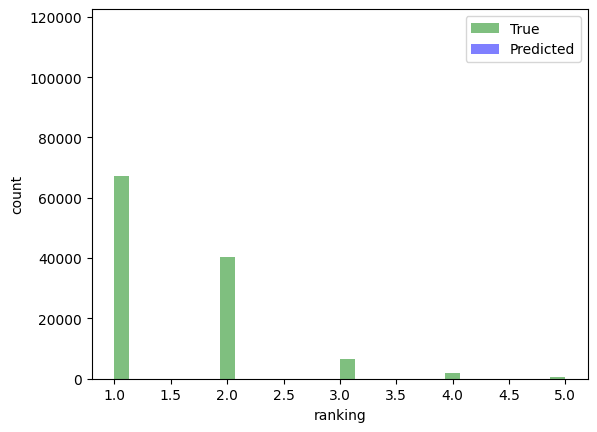

In [41]:

h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [15]:
########## MODEL LOADING ##########
model_name = "models/recommenderv2.h5"
from stellargraph.layer import MeanHinAggregator, LinkEmbedding

# def root_mean_square_error(s_true, s_pred):
#     return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))

loaded_model = load_model(model_name, custom_objects={
    # 'root_mean_square_error': root_mean_square_error,
    'MeanHinAggregator': MeanHinAggregator,
    'LinkEmbedding': LinkEmbedding
})

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
############## STELLAR AP EVAL #############

def AP_at_K(model, generator, raw_edgelist_test, edgelist_train=None, k=10):
    user_nodes = set([edge.source for edge in raw_edgelist_test])
    # contract_nodes_train = set([edge.target for edge in edgelist_train]) # If just wanna predict score for contracts that were in trainset
    # contract_nodes = contract_nodes_test.intersection(contract_nodes_train)

    avg_precisions = []
    count = 0
    # edgelist = edgelist_test + edgelist_train # A favor to model, we compare the prediction with all items user had interacted with (train, and tesset)
    
    for user in tqdm(user_nodes, total=len(user_nodes)):
        contract_nodes_ground_truth = set([edge.target for edge in raw_edgelist_test if edge.source == user])
        contract_nodes_neg_samples = set([edge.target for edge in raw_edgelist_test if edge.source != user])
        contract_nodes_neg_samples = random.sample(contract_nodes_neg_samples, 100) 
        contract_nodes = contract_nodes_ground_truth.union(set(contract_nodes_neg_samples))
        potential_edges = [(user, contract) for contract in contract_nodes]
        input_gen = generator.flow(potential_edges)
        predictions = model.predict(input_gen).flatten()
        sorted_indices = np.argsort(predictions)[::-1]
        top_k_contracts = [potential_edges[i][1] for i in sorted_indices[:k]]
        actual_contracts = [edge.target for edge in raw_edgelist_test if edge.source == user]
        relevant_items = set(top_k_contracts).intersection(set(actual_contracts))
        precision_k = len(relevant_items) / min(len(actual_contracts), k)
        avg_precisions.append(precision_k)
        count += 1
        if count % 20 == 0: print(np.mean(avg_precisions))
        
    return np.mean(avg_precisions)

k_value = 10
model = loaded_model
average_precision = AP_at_K(model, generator, raw_edgelist_test, '', k_value)
print(f"AP@{k_value}:", average_precision)
